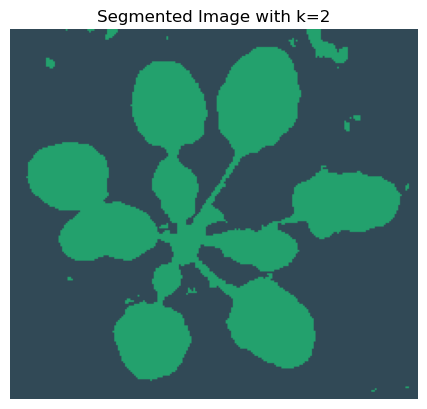

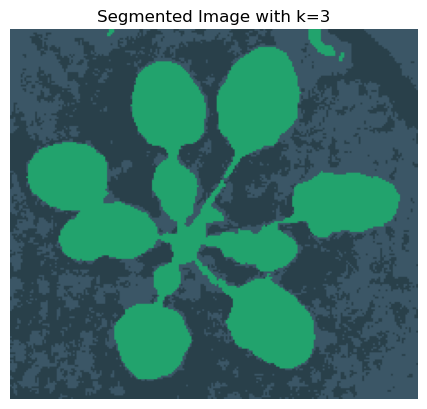

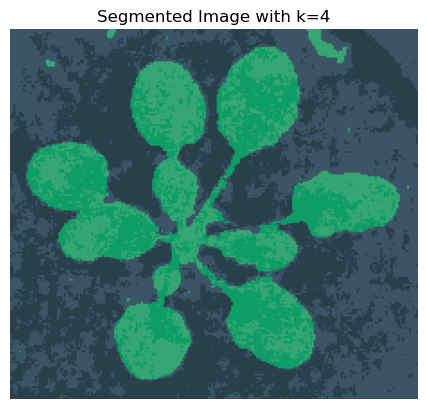

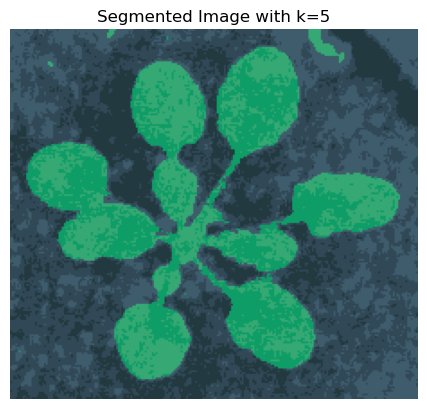

To determine the k value we analyzded which is the best for the segmentation. we decided to k=3


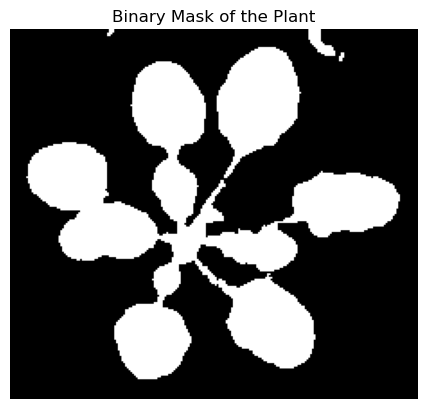

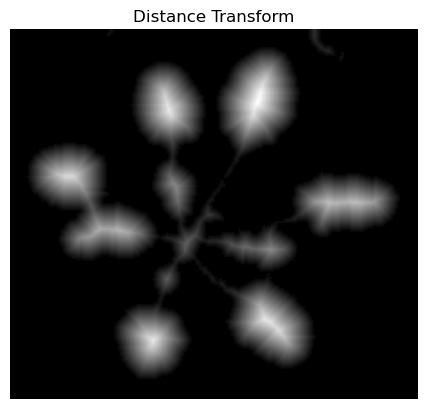

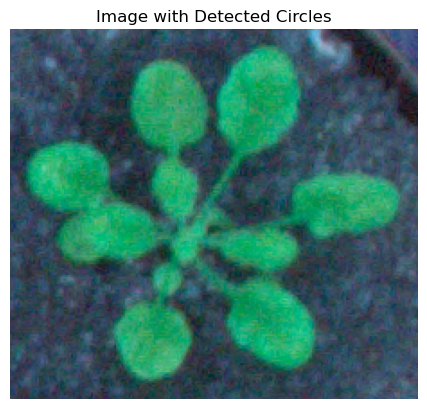

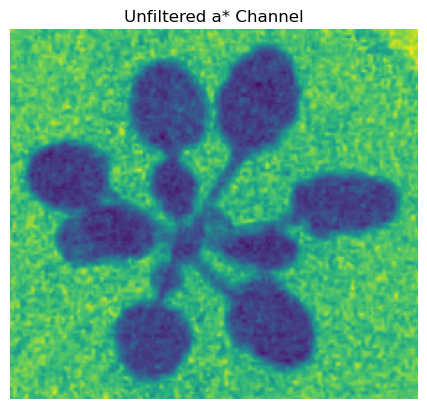

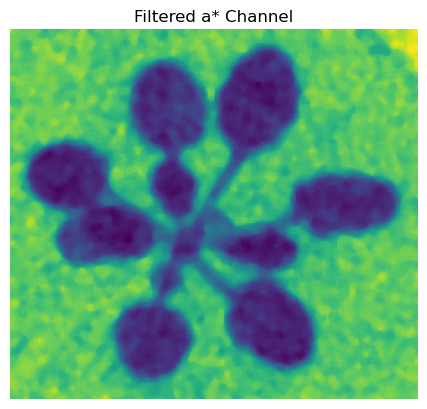

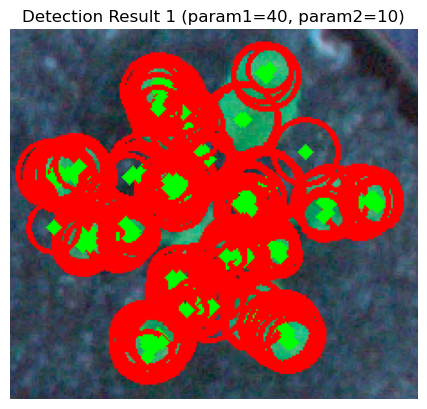

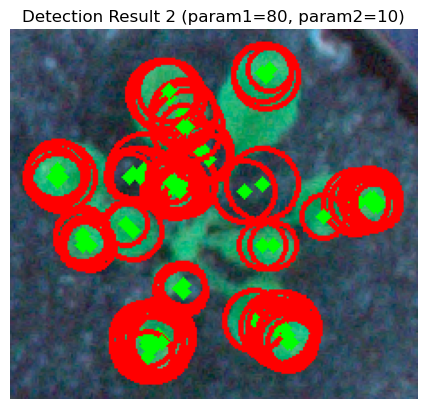

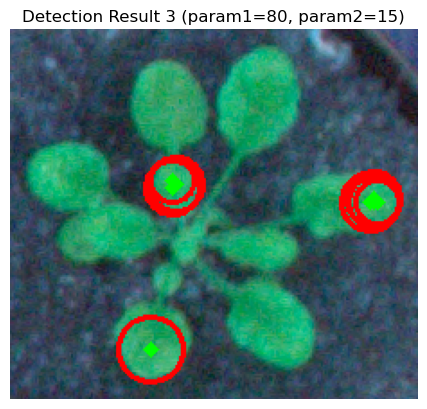

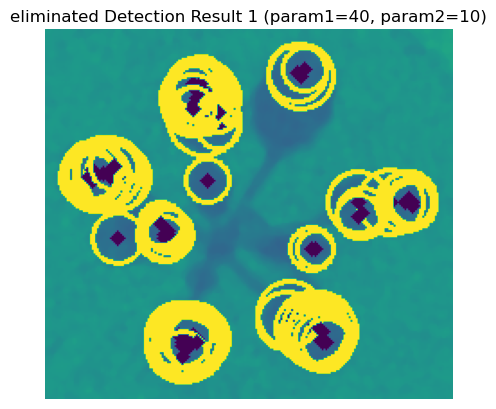

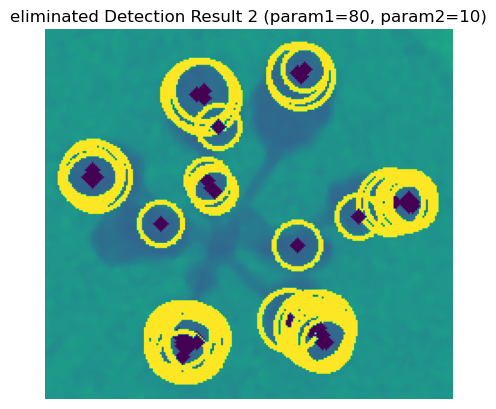

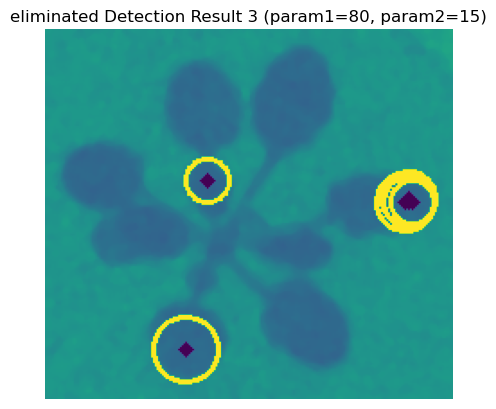

In [1]:
# Fatih Yiğitel, Barış Sinaplı
import cv2
import numpy as np
import matplotlib.pyplot as plt

# In this function we display color images
def display_image(img, title='Image', cmap=None):
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# In this function we display grayscale images
def display_image_gray(img, title='Image'):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

    
#In this function we detect tle leaves and draw the circles with this function
#input_image: The image on which circles are detected.
#min_radius: The minimum radius of circles to be detected.
#max_radius: The maximum radius of circles to be detected.
#param1: The first method-specific parameter of the HoughCircles method.
#param2: The second method-specific parameter of the HoughCircles method.
#title: The title to be displayed when showing the image with detected circles.

def detect_and_draw_circles(input_image, min_radius, max_radius, param1, param2, title):
    # We detect circles with using HoughCircles method from library
    circles = cv2.HoughCircles(input_image, cv2.HOUGH_GRADIENT, 1, minDist=0.1, param1=param1, param2=param2, minRadius=min_radius, maxRadius=max_radius)

    # We create a copy of the original image to draw detected circles in here
    img_with_circles = img.copy()

    # In here we draw detected circles on the copy of the original image
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            center = (circle[0], circle[1])
            radius = circle[2]

            #we draaw the circle
            cv2.circle(img_with_circles, center, radius, (255, 0, 0), 2)

            #we draw the circle's center in here
            cv2.circle(img_with_circles, center, 2, (0, 255, 0), 3)

    # Lastly we show the image with detected circles
    display_image(img_with_circles, f'{title} (param1={param1}, param2={param2})')    

    
    
#In here we use binary mask and we provide elimination of the circles with using binary mask in the eliminated_detect_and_draw_circles method

def eliminated_detect_and_draw_circles(input_image, binary_mask, min_radius, max_radius, param1, param2, title, area_ratio_threshold=0.9):
    # Detect circles using HoughCircles
    circles = cv2.HoughCircles(input_image, cv2.HOUGH_GRADIENT, 1, minDist=0.1, param1=param1, param2=param2, minRadius=min_radius, maxRadius=max_radius)

    #We create a copy of the original image to draw detected circles
    img_with_circles = input_image.copy()

    #We draw detected circles in the copy of the original image
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            center = (circle[0], circle[1])
            radius = circle[2]

            # we ignore the circle if its center is not in the plant area n here
            if binary_mask[center[1], center[0]] == 0:  # y first, x second for numpy array indexing
                continue

            # Later we eliminate circles if they don't have enough area within the plant's region
            # and we create a mask of the circle
            circle_mask = np.zeros(binary_mask.shape, dtype=np.uint8)
            cv2.circle(circle_mask, center, radius, 1, -1)  # -1 means filled circle

            # To calculate the ratio of the circle's area that falls within the plant area
            circle_area = np.sum(circle_mask)
            circle_plant_area = np.sum(binary_mask & circle_mask)
            area_ratio = circle_plant_area / circle_area if circle_area != 0 else 0

            # we ignore the circle if the area ratio is below the threshold
            if area_ratio < area_ratio_threshold:
                continue

            # In here we draw the circle
            cv2.circle(img_with_circles, center, radius, (255, 0, 0), 2)

            # IN here we draw the circle's center
            cv2.circle(img_with_circles, center, 2, (0, 255, 0), 3)

    # Display the image with detected circles
    display_image(img_with_circles, f'{title} (param1={param1}, param2={param2})')




# We do that same stesps in the first task, we read images and we convert floating points and we set to minimize the distance between each data point and its corresponding cluster center. 
img = cv2.imread('ara2012_plant004_rgb.png')
img_float = np.float32(img)
pixels = img_float.reshape((-1, 3))
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)


#We take this code from the first part

# To determine the correct parameter of the value of k we use segmentation with different numbers
for k in [2, 3, 4, 5]:
    # We applies k-means clustering with using kmeans function form library
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # we change the cluster centers back to 8-bit values
    centers = np.uint8(centers)

    # In here each pixel changed with the color of its cluster center
    segmented_img = centers[labels.flatten()].reshape(img.shape)
    
    # Later we shows segmented image
    display_image(segmented_img, f'Segmented Image with k={k}')
    

print("To determine the k value we analyzded which is the best for the segmentation. we decided to k=3")


# We do that same stesps above
img = cv2.imread('ara2012_plant004_rgb.png')
img_float = np.float32(img)
pixels = img_float.reshape((-1, 3))
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

# Best value of h and use kmeans clustering
best_k = 3
_, labels, centers = cv2.kmeans(pixels, best_k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)

# we finnd the label that corresponse to the plant segment that base on the green channel
plant_label = np.argmax(centers[:, 1])  
# we assumes that the plant area has a higher green channel value

# In here to arrange the labels the labels are resahped to match the original image shape
labels_reshaped = labels.reshape(img.shape[:2])

# We create a binary mask that shows the plant segment
binary_mask = np.where(labels_reshaped == plant_label, 255, 0).astype('uint8')

# Lastly we get the binary mask of image
display_image_gray(binary_mask, 'Binary Mask of the Plant')


# We convert the binary mask to an 8-bit image
binary_mask_8bit = np.uint8(binary_mask * 255)

# Gaussian blur is applied in here  to reduce noise
blur = cv2.GaussianBlur(binary_mask_8bit, (9, 9), 2)

#We compute the distance transform of the binary mask
dist_transform = cv2.distanceTransform(binary_mask_8bit, cv2.DIST_L2, 3)

# We find the maximum value of the distance transform
max_value = np.max(dist_transform)

# In here we display the distance transform
display_image_gray(dist_transform, 'Distance Transform')

# In here we assume that minRadius is half of the max radius and maxRadius is equal to max_value
minRadius = int(max_value / 2)
maxRadius = int(max_value)

#print(minRadius)
#print(maxRadius)

# In here we call HoughCircles method the detect the cricles
circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1, minDist=0.1, param1=50, param2=30, minRadius=minRadius, maxRadius=maxRadius)

# We draw detected circles on the original image
if circles is not None:
    circles = np.uint16(np.around(circles))
    for circle in circles[0, :]:
        center = (circle[0], circle[1])
        radius = circle[2]

        # We draw the circle
        cv2.circle(img, center, radius, (255, 0, 0), 2)

        # We draw the circle's center
        cv2.circle(img, center, 2, (0, 255, 0), 3)

# In here we display the image with detected circles
display_image(img, 'Image with Detected Circles')

#We use lab colors we extarct*a, and display the unfiltered a* channel at last
lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
a_channel = lab_img[:, :, 1]
display_image(a_channel, 'Unfiltered a* Channel')

# We pply median filtering to the a* channel with a kernel size of 5
filtered_a_channel = cv2.medianBlur(a_channel, 5)

# We display the filtered a* channel
display_image(filtered_a_channel, 'Filtered a* Channel')

# Lastly we convert the filtered a* channel to an 8-bit image
filtered_a_channel_8bit = np.uint8(filtered_a_channel)


# we display the detection of the results

# First detection result
detect_and_draw_circles(filtered_a_channel_8bit, minRadius, maxRadius, param1=40, param2=10, title='Detection Result 1')

# Second detection result
detect_and_draw_circles(filtered_a_channel_8bit, minRadius, maxRadius, param1=80, param2=10, title='Detection Result 2')

# Third detection result
detect_and_draw_circles(filtered_a_channel_8bit, minRadius, maxRadius, param1=80, param2=15, title='Detection Result 3')


# First detection result
eliminated_detect_and_draw_circles(filtered_a_channel_8bit, binary_mask, minRadius, maxRadius, param1=40, param2=10, title='eliminated Detection Result 1')

# Second detection result
eliminated_detect_and_draw_circles(filtered_a_channel_8bit, binary_mask, minRadius, maxRadius, param1=80, param2=10, title='eliminated Detection Result 2')

# Third detection result
eliminated_detect_and_draw_circles(filtered_a_channel_8bit, binary_mask, minRadius, maxRadius, param1=80, param2=15, title='eliminated Detection Result 3')



